In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import gcsfs
import os

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import set_gpu_default_device

In [2]:
def standardize_dates(ds):
    """
    Convert the 'time' dimension in an xarray dataset to date-only format (remove time component).
    
    Parameters:
    ds (xarray.Dataset): The dataset whose 'time' dimension you wish to modify.
    
    Returns:
    xarray.Dataset: Modified dataset with standardized date format.
    """
    # Ensure 'time' is a coordinate in your dataset
    if 'time' in ds.coords:
        # Convert time coordinates to date-only, ensuring format is consistent
        ds['time'] = ds['time'].dt.floor('D')
    
    return ds

# Data Loader

In [3]:
# Path to your Zarr stores
ice_concentration_path = 'gs://great-lakes-osd/ice_concentration.zarr'
glsea_path = 'gs://great-lakes-osd/GLSEA_combined.zarr'
glsea3_path = 'gs://great-lakes-osd/GLSEA3_combined.zarr'

# Open the Zarr stores
ice_concentration_raw = xr.open_zarr(ice_concentration_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea_raw = xr.open_zarr(glsea_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea3_raw = xr.open_zarr(glsea3_path, chunks={'time': 366, 'lat': 200, 'lon': 200})

# Replace -1 (land value) with NaN
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)
glsea3_raw = standardize_dates(glsea3_raw)

# Drop CRS - not needed
glsea_raw = glsea_raw.drop_vars('crs')
glsea3_raw = glsea3_raw.drop_vars('crs')

In [4]:
# Set up GCS filesystem
fs = gcsfs.GCSFileSystem(project='your-gcp-project')

# Path to the NetCDF files 
context_path = 'gs://great-lakes-osd/context/'

# Open the NetCDF files using xarray with gcsfs
bathymetry_raw = xr.open_dataset(fs.open(os.path.join(context_path, 'interpolated_bathymetry.nc')))
lakemask_raw = xr.open_dataset(fs.open(os.path.join(context_path, 'lakemask.nc')))

# Name the bathymetry variable
bathymetry_raw = bathymetry_raw.rename({'__xarray_dataarray_variable__': 'bathymetry'})

# Data Processor

In [5]:
data_processor = DataProcessor(x1_name="lat", x2_name="lon")

#glsea = data_processor(glsea_raw)
_ = data_processor(glsea_raw.sel(time=slice("2009-01-01", "2009-12-31")))
glsea = data_processor(glsea_raw)

# process the bathymetry and lake
aux_ds, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [6]:
# Select a subset of the ice concentration data to compute normalization parameters
_ = data_processor(ice_concentration_raw.sel(time=slice("2009-01-01", "2009-12-31")))

# Now apply the normalization parameters to the full ice concentration dataset
ice_concentration = data_processor(ice_concentration_raw)


In [7]:
data_processor.config

{'coords': {'time': {'name': 'time'},
  'x1': {'name': 'lat', 'map': (38.8749871947229, 55.4132976408956)},
  'x2': {'name': 'lon', 'map': (-92.4199507342304, -75.8816402880577)}},
 'sst': {'method': 'mean_std',
  'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}},
 'bathymetry': {'method': 'min_max',
  'params': {'min': 9.999999999999998, 'max': 316.62872313037894}},
 'mask': {'method': 'min_max', 'params': {'min': 0.0, 'max': 1.0}},
 'ice_concentration': {'method': 'mean_std',
  'params': {'mean': 11.848304453395341, 'std': 28.78266463694381}}}

In [8]:
dates = pd.date_range(glsea.time.values.min(), glsea.time.values.max(), freq="D")

In [9]:
doy_ds = construct_circ_time_ds(dates, freq="D")
#cosD = doy_ds["cos_D"]
#sinD = doy_ds["sin_D"]
aux_ds["cos_D"] = doy_ds["cos_D"]
aux_ds["sin_D"] = doy_ds["sin_D"]

In [10]:
dates

DatetimeIndex(['1995-01-01', '1995-01-02', '1995-01-03', '1995-01-04',
               '1995-01-05', '1995-01-06', '1995-01-07', '1995-01-08',
               '1995-01-09', '1995-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=10227, freq='D')

In [11]:
aux_ds

<xarray.Dataset> Size: 941kB
Dimensions:     (x1: 240, x2: 360, time: 10227)
Coordinates:
  * x1          (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2          (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9791 0.9818
  * time        (time) datetime64[ns] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
Data variables:
    bathymetry  (x1, x2) float64 691kB nan nan nan nan nan ... nan nan nan nan
    cos_D       (time) float64 82kB 0.9999 0.9994 0.9987 ... 0.9993 0.9998 1.0
    sin_D       (time) float64 82kB 0.0172 0.0344 0.05158 ... -0.0215 -0.004301

# Tasks

## Generating random coordinates from inside the mask

In [25]:
def generate_random_coordinates(mask_da, N):
    """
    Generate N random normalized coordinates (x1, x2) within a given xarray mask.

    Parameters:
    mask_da (xarray.DataArray): 2D binary mask with 1.0 indicating valid points (e.g., lake areas).
    N (int): Number of random coordinates to generate.

    Returns:
    numpy.ndarray: Array of shape (2, N) with normalized random x1, x2 coordinates.
    """
    # Convert the xarray DataArray mask to a numpy array
    mask = mask_da.values

    # Get the valid indices where the mask is 1 (valid areas like lakes)
    valid_indices = np.argwhere(mask == 1.0)

    # Check if N is greater than the number of valid points
    if N > valid_indices.shape[0]:
        raise ValueError("N is greater than the number of valid points in the mask.")

    # Randomly select N points from the valid indices
    random_indices = valid_indices[np.random.choice(valid_indices.shape[0], N, replace=False)]

    # Separate the indices into x1 and x2
    x1_coords = random_indices[:, 0]
    x2_coords = random_indices[:, 1]

    # Normalize the coordinates
    x1_min, x1_max = 0, mask.shape[0] - 1
    x2_min, x2_max = 0, mask.shape[1] - 1

    normalized_x1 = (x1_coords - x1_min) / (x1_max - x1_min)
    normalized_x2 = (x2_coords - x2_min) / (x2_max - x2_min)

    # Combine into a single ndarray of shape (2, N)
    random_coords = np.vstack((normalized_x1, normalized_x2))

    return random_coords


In [28]:
# Generate random coordinates within the lakes
N = 10
random_lake_points = generate_random_coordinates(lakemask.mask, N)

print(random_lake_points)

[[0.72879331 0.5818399  0.82317802 0.42532855 0.30943847 0.27359618
  0.76583035 0.38351254 0.28434886 0.40979689]
 [0.16694915 0.37627119 0.27711864 0.30084746 0.68559322 0.72542373
  0.24915254 0.88644068 0.31186441 0.96271186]]


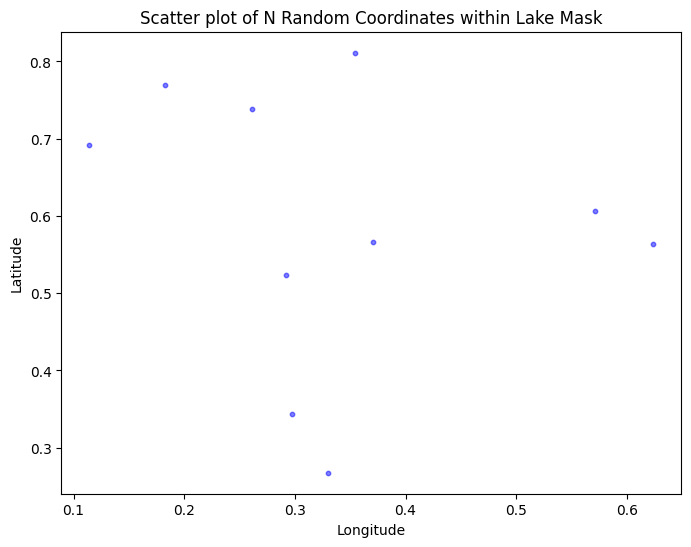

In [27]:
import matplotlib.pyplot as plt

# Assuming random_coords is the (2, N) array from the previous step
latitudes = random_lake_points[0, :]
longitudes = random_lake_points[1, :]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of N Random Coordinates within Lake Mask")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [12]:
from deepsensor.data import TaskLoader
task_loader = TaskLoader(context=[glsea, ice_concentration, aux_ds, lakemask], target=glsea)

In [29]:
task_loader.context

(<xarray.Dataset> Size: 40GB
 Dimensions:  (time: 10221, x1: 838, x2: 1181)
 Coordinates:
   * time     (time) datetime64[ns] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
   * x1       (x1) float32 3kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
   * x2       (x2) float32 5kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
 Data variables:
     sst      (time, x1, x2) float32 40GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
 Attributes:
     CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
     CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
     Conventions:  CF-1.5
     GDAL:         GDAL 2.1.3, released 2017/20/01
     history:      Tue Feb 13 20:15:43 2024: cdo selyear,1995 GLSEA_SST_1995_2...
     source:       1995_001_glsea.asc
     title:        SST from Great Lakes Surface Environmental Analysis (GLSEA),
 <xarray.Dataset> Size: 77GB
 Dimensions:            (time: 18434, x1: 1024, x2: 1024)
 Coordinates:
   * tim

In [18]:
task = task_loader("2011-08-16", context_sampling=random_lake_points, target_sampling="all")

InvalidSamplingStrategyError: Passed a numpy coordinate array to sample xarray object, but the coordinates are out of bounds.

In [ ]:
dates

In [24]:
random_lake_points[0,:].max()

np.float64(0.8446833930704899)